In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt


from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0


In [2]:


base_path = f'Z:\\cid\\na'
save_path = f'data\\nematic\\na'

extract = True
analyze = True
save_figs = True
verbose = True

ordering='z' # 'h' for hilbert, 'z' for z-order
data_suffix = 's'  # 'sd', 'ndg', 's', 'f' or ''    
use_seq = False
seq_prefix = '_seq' if use_seq else ''
ordering_suffix = 'zorder' if ordering=='z' else ''

nbits = 8
window_size=512
nframes = 4
cg = 4

if ordering == 'h':
    output_suffix = f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}'
elif ordering == 'z':
    output_suffix = f'_nx{window_size}nt{nframes}cg{cg}'

#output_suffix = f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}'
data_dict = {}
sd_data_dict = {'data_suffix': 'sd',
   # 'output_suffix': f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [512],
    'Nexp_list': [10],
    'act_exclude_dict': {512: []},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022
    }

naz_data_dict = {
    'data_suffix': '_zorder',
   # 'output_suffix': f'_nx{window_size}nt{nframes}cg{cg}',
    'L_list': [512],
    'Nexp_list': [5],
    'act_exclude_dict': {512: [0.02, 0.0225, 0.0235]},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022
}

na_data_dict = {
    'data_suffix': '',
 #   'output_suffix': f'_nb{nbits}cg{cg}',
    'L_list': [512, 1024, 2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {512: [0.02, 0.0225], 1024: [], 2048: [0.0225]},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022
}
naf_data_dict = {
    'data_suffix': 'f',
 #   'output_suffix': f'_nb{nbits}cg{cg}',
    'L_list': [1024],
    'Nexp_list': [5],
    'act_exclude_dict': {1024: [0.0235],},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022
}


ndg_data_dict = {
    'data_suffix': 'ndg',
  #  'output_suffix': f'_nb{nbits}cg{cg}',
    'L_list': [1024],
    'Nexp_list': [1],
    'act_exclude_dict': {1024: []},
    'xlims': None,
    'uncertainty_multiplier': 20,
    'act_critical': 0.65
    }

s_data_dict = {
    'data_suffix': 's',
 #   'output_suffix': f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}',
    'L_list': [2048],
    'Nexp_list': [3],
    'act_exclude_dict': {2048: []},
    'xlims': None,
    'uncertainty_multiplier': 5,
    'act_critical': 2.1
    }

nanb7_data_dict = {
    'data_suffix': '',
  #  'output_suffix': f'_nb{nbits}cg{cg}',
    'L_list': [1024,2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {1024: [], 2048: [0.0225]},
    'xlims': (0.016, 0.045),
    'uncertainty_multiplier': 20,
    'act_critical': 0.022
    }

data_dict = {'sd': sd_data_dict,
            'ndg': ndg_data_dict, 
            '': na_data_dict,
            'f': naf_data_dict,
            's': s_data_dict,
      #      '_zorder': zorder_data_dict,
            }

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'output_suffix': output_suffix,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,   
    **data_dict[data_suffix]
}
#output_suffix = data_dict[data_suffix]['output_suffix']
fig_folder = 'na' if data_suffix == '' else data_suffix
figs_save_path = f'data\\nematic\\figs\\{fig_folder}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict, load_data=not extract)

# Set figure save path
ac.figs_save_path = figs_save_path

if extract:
    #conv_list_dir = save_path + '512'
    ac.run() #conv_list_dir = conv_list_dir)
if analyze and not extract:
    ac.analyze()


=== Starting CID analysis ===
[Extract] LX=2048 | data_path=Z:\cid\na2048s
cid data saved to data\nematic\na2048s\cid_data_nx512nt4cg4.npz
Error loading conv_list for LX=2048: [Errno 2] No such file or directory: 'data\\nematic\\na2048s\\conv_list.npy'
initializing all-zero conv_list.
[Analyze] LX=2048 | saved processed data to data\nematic\na2048s\cid_time_av_nx512nt4cg4.npz
=== Extraction & Analysis complete ===


In [3]:
os.listdir('Z:')

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'Z:'

In [3]:
np.logspace(0,4,base=10, num=5).astype(int)

array([    1,    10,   100,  1000, 10000])

In [7]:
n_list=np.logspace(0,4,base=10, num=5).astype(int)
cid_vals = []
for n in n_list:
    x=np.arange(n).astype(int)
    cid_vals.append(cid(x))
cid_vals, np.log2(n_list)

([0.0,
  3.3219280948873626,
  5.6827315074437195,
  7.9728967514644475,
  10.230460288877318],
 array([ 0.        ,  3.32192809,  6.64385619,  9.96578428, 13.28771238]))

In [45]:
ac.act

{512: array([0.0195, 0.0205, 0.021 , 0.0215, 0.022 , 0.023 , 0.024 , 0.0245,
        0.025 , 0.0255, 0.026 , 0.027 , 0.028 , 0.029 , 0.03  , 0.032 ,
        0.034 , 0.04  , 0.05  , 0.06  , 0.07  ])}

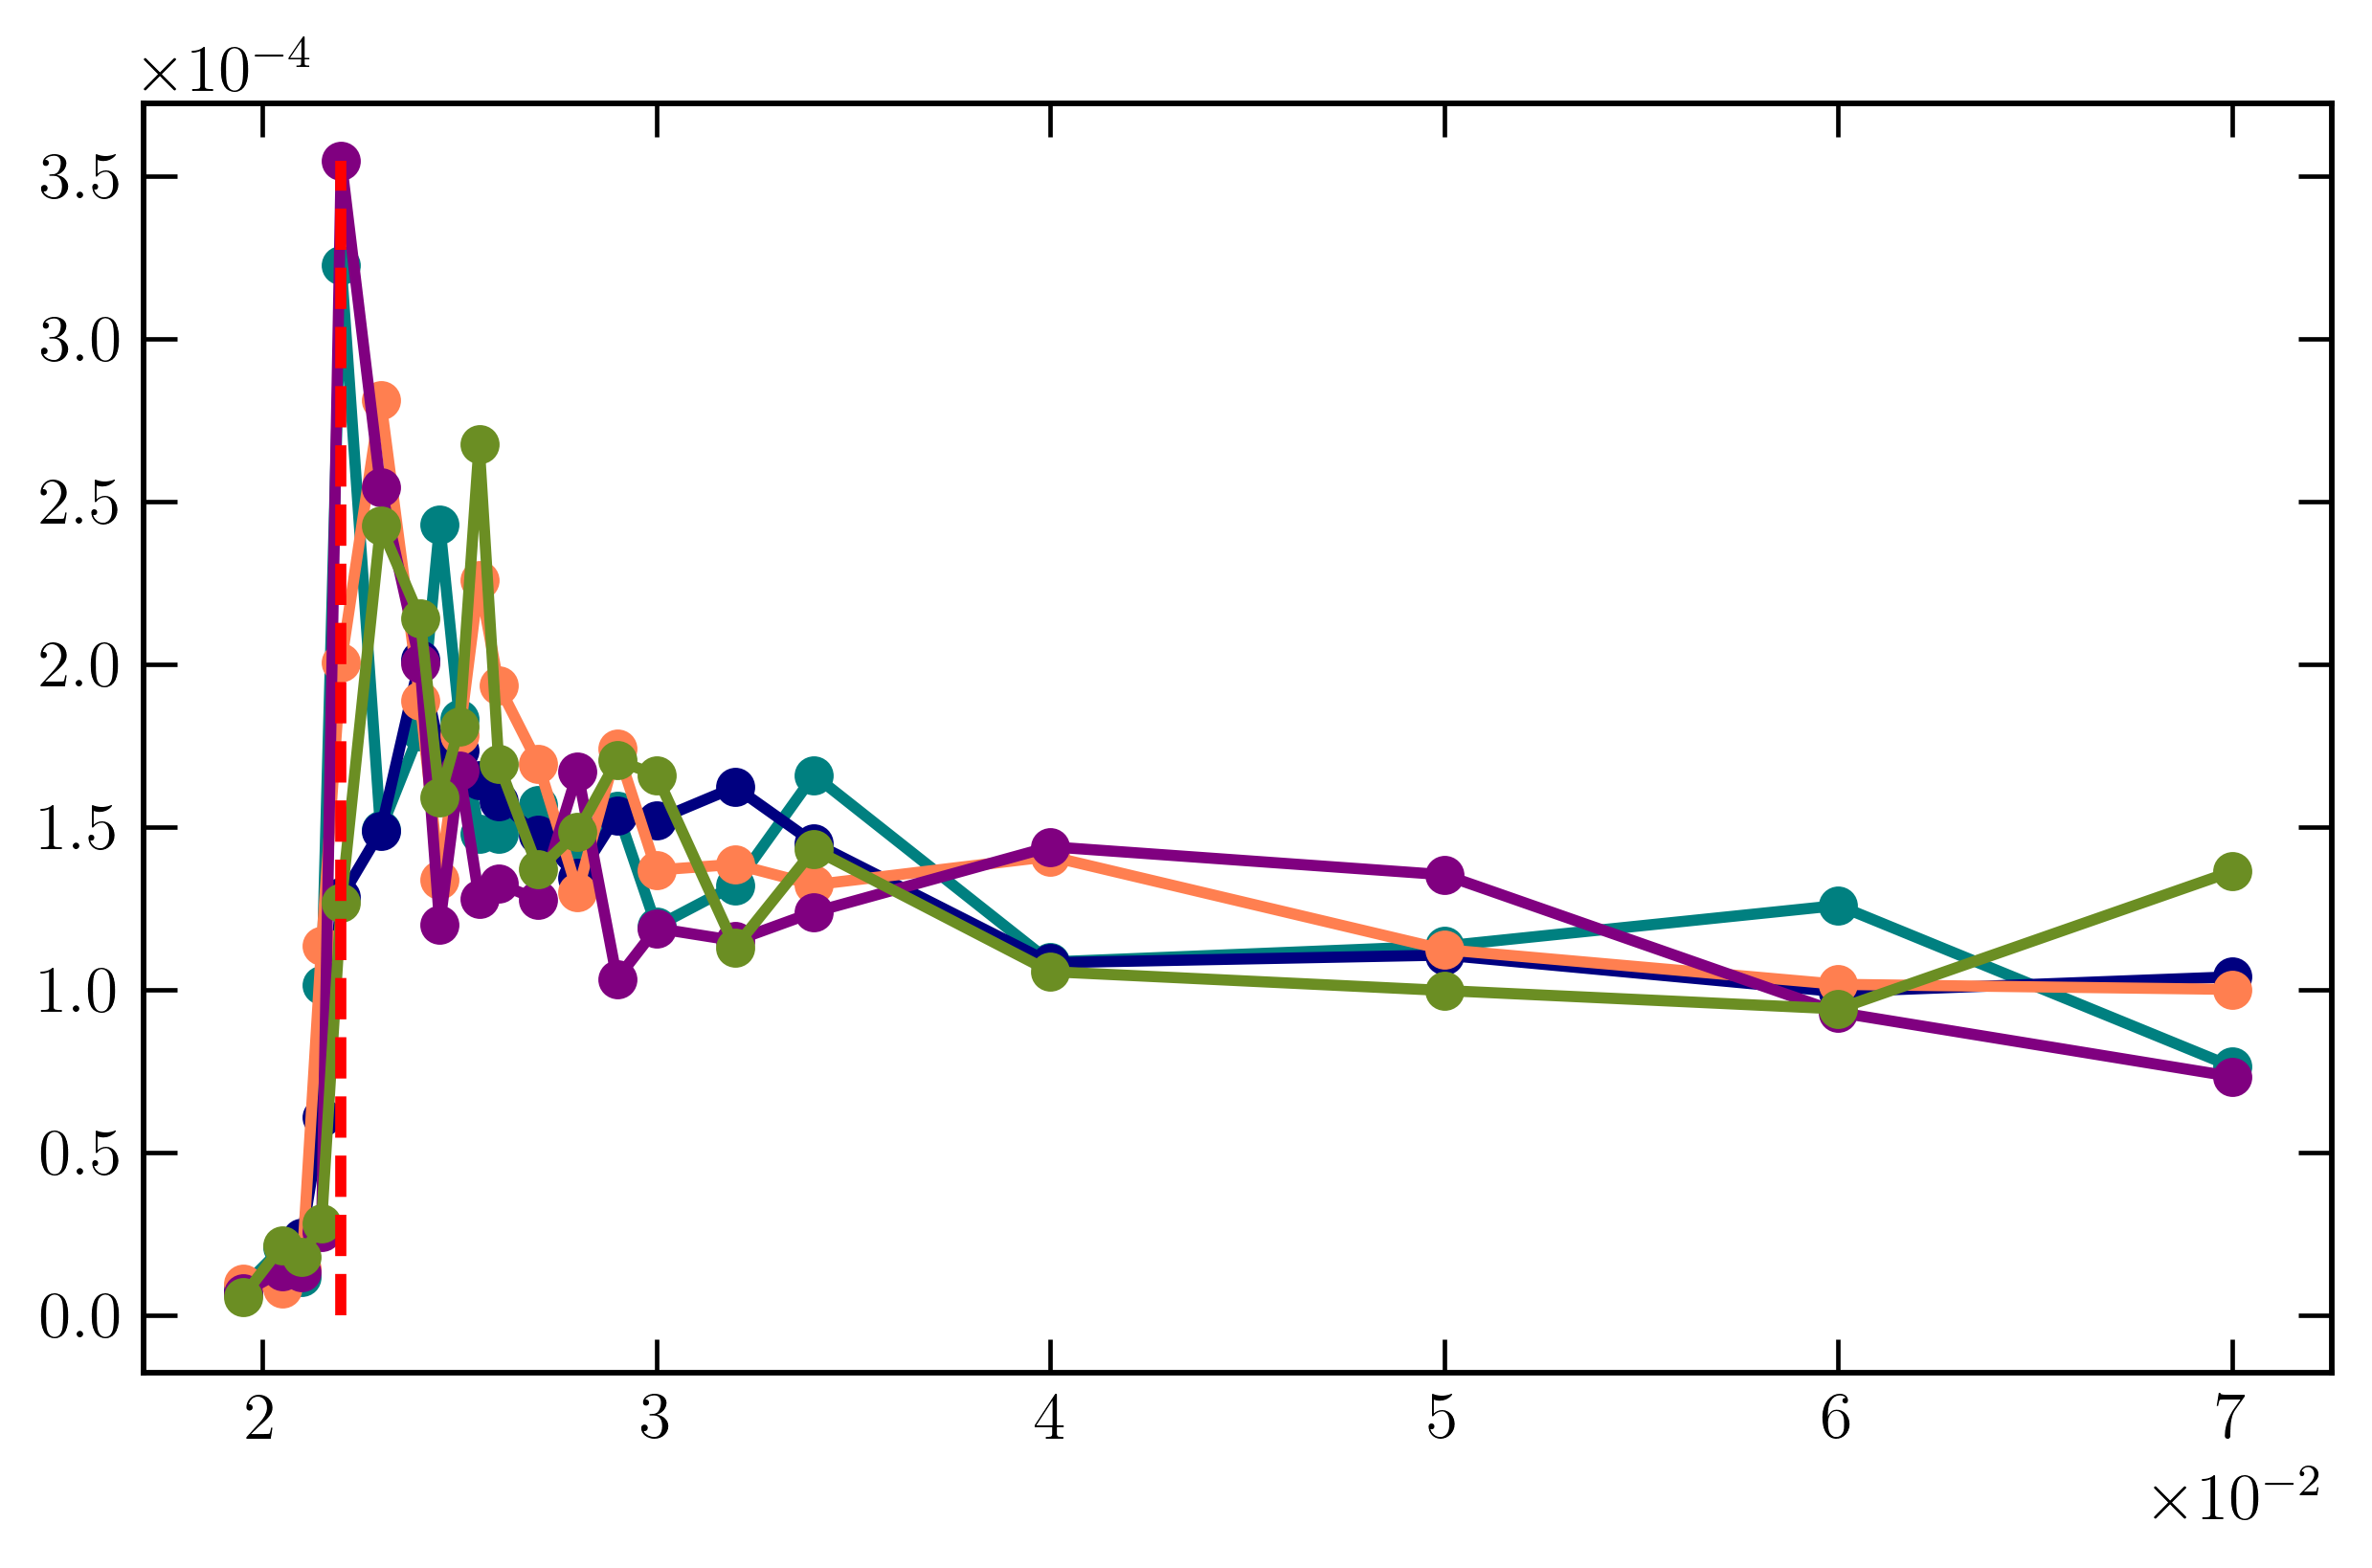

In [44]:
cid_av_exp = np.nanvar(ac.cid[512][...,0], axis=(0,1))
# plot CID vs act for different exp
fig, ax = plt.subplots(figsize=(6,4))
for iexp in range(ac.Nexp[512]):
    ax.plot(ac.act[512], cid_av_exp[:,iexp], marker='o', label=f'Exp {iexp+1}')
ax.vlines(0.022, ymin=0, ymax=np.nanmax(cid_av_exp), colors='r', linestyles='dashed', label='Critical Activity')

In [30]:
ac.cid_var

{512: array([[4.96839588e-06, 6.84389823e-07],
        [1.07820583e-05, 1.58824931e-06],
        [1.25129601e-05, 1.41569904e-06],
        [5.49641153e-05, 1.41996468e-05],
        [1.93756413e-04, 4.14168430e-05],
        [1.64783105e-04, 2.34346584e-05],
        [2.45403169e-04, 5.46470282e-05],
        [1.30864898e-04, 4.58404618e-06],
        [9.13363717e-05, 1.68367278e-05],
        [1.03948977e-04, 5.29162522e-06],
        [1.17261390e-04, 2.62403972e-05],
        [9.04488729e-05, 6.63841802e-06],
        [7.89583836e-05, 8.21698434e-06],
        [7.03934690e-05, 4.75477904e-06],
        [6.31666888e-05, 3.04128596e-06],
        [4.92187757e-05, 5.06099863e-06],
        [5.35522659e-05, 3.24498628e-06],
        [4.68231796e-05, 6.73465889e-06],
        [3.38391468e-05, 3.18804810e-06],
        [3.03232309e-05, 3.12023908e-06],
        [2.82320971e-05, 4.89083269e-06],
        [2.61621625e-05, 3.90677411e-06]])}

In [ ]:
plot_abs=True
use_min=True
ac.plot_cid_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs, use_min=use_min);
ac.plot_div_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs, use_min=use_min);

In [12]:
ac.frac_tav[LX][:,0]

array([0.99862312, 0.99788158, 0.99613975, 0.9877594 , 0.97191832,
       0.95068208, 0.92014467, 0.90902948, 0.93639828, 0.94954961])

Figure saved to: data\nematic\figs\na\nb5cg4\divm_ddiv.pdf


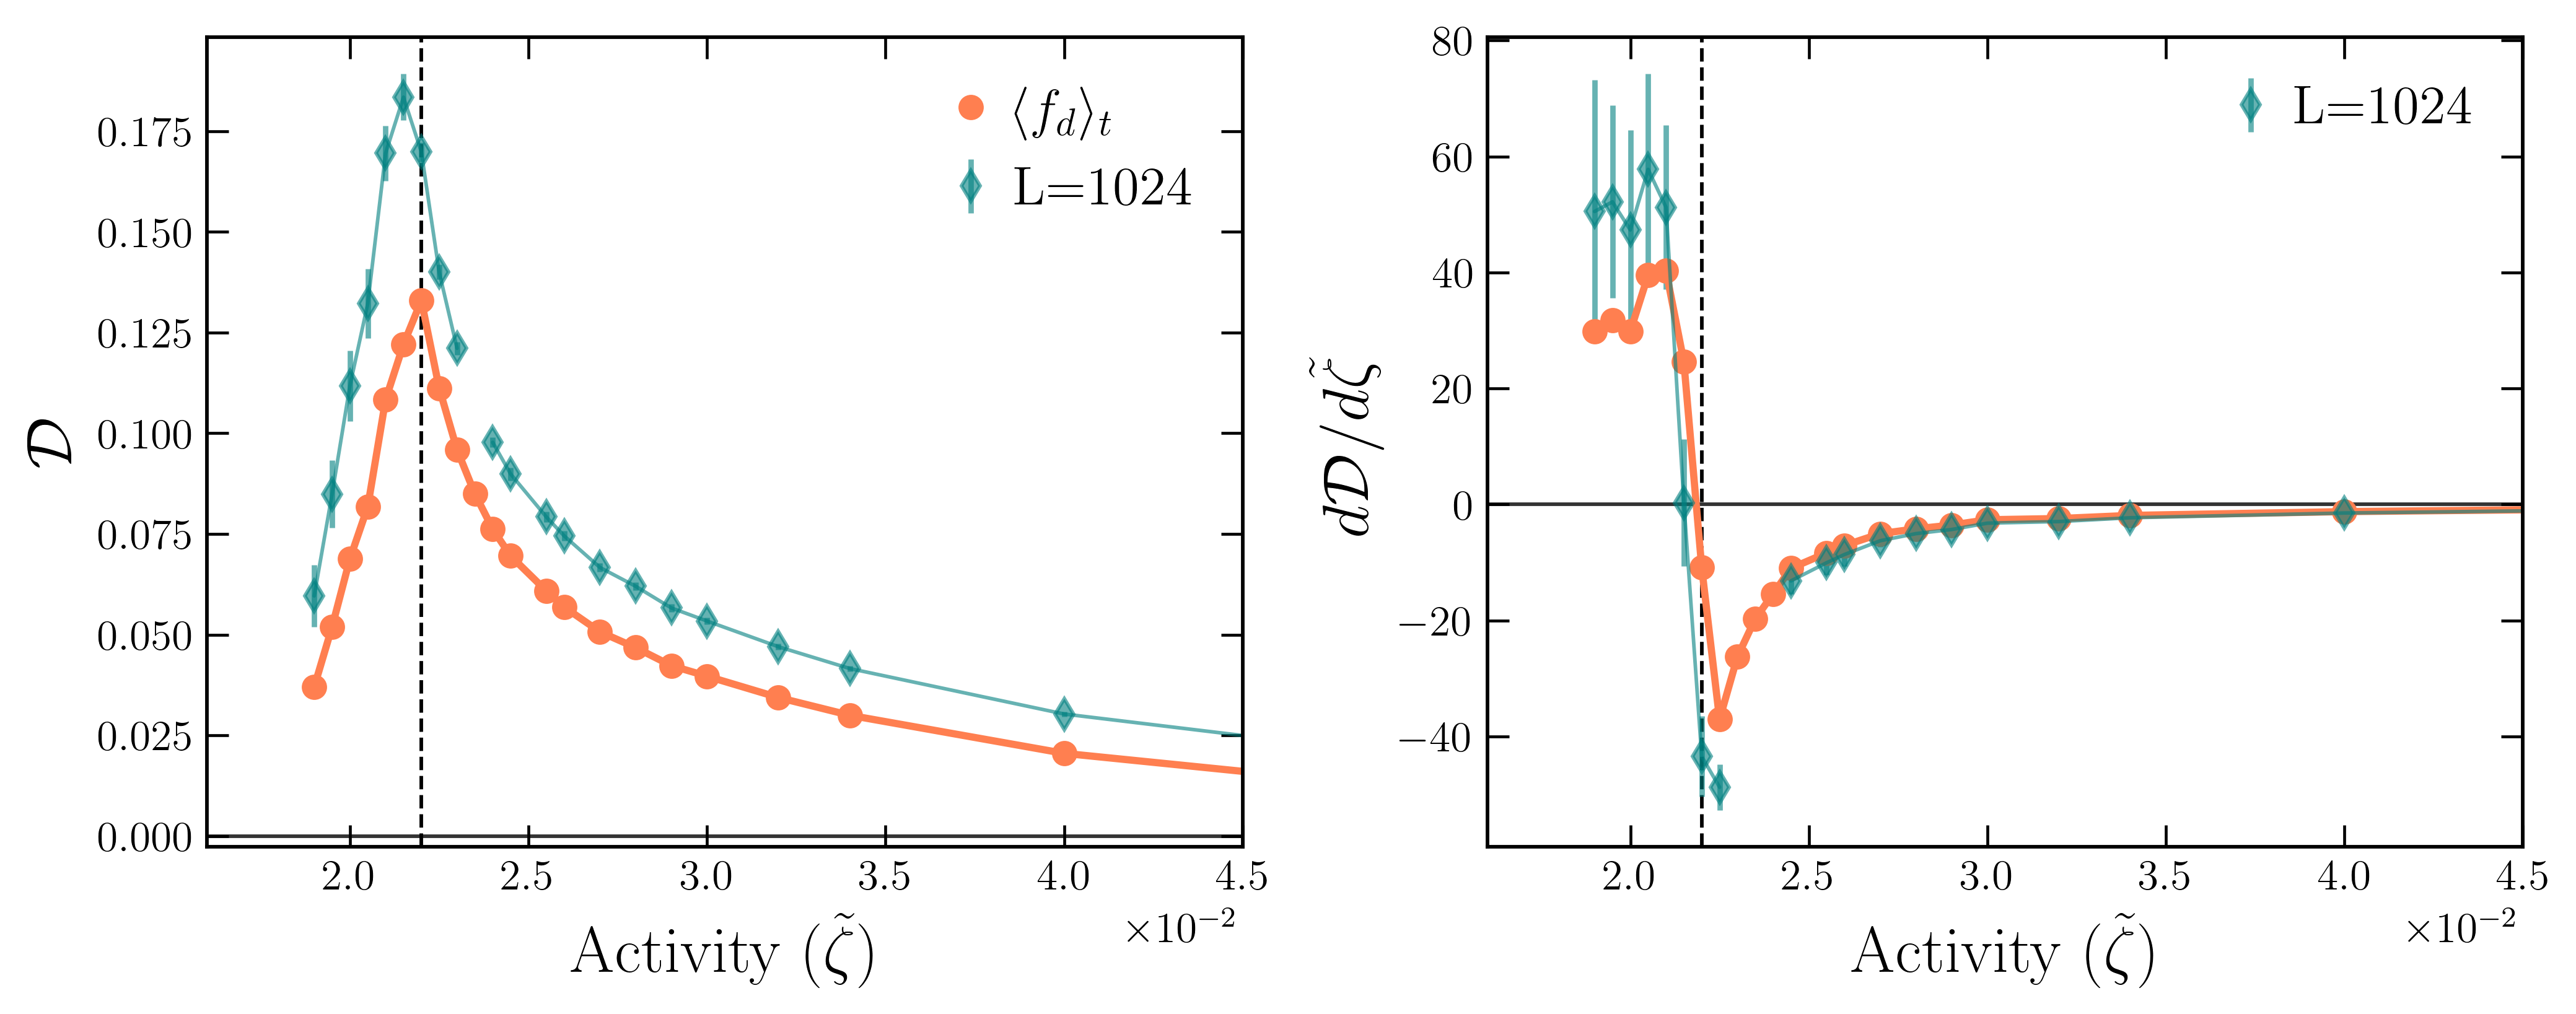

In [17]:
use_min=True
LX = 1024
fig, ax = ac.plot_div_and_deriv(L_list = [LX],save_path=ac.figs_save_path, 
                                act_critical=cid_dict['act_critical'], 
                                xlims=cid_dict['xlims'], 
                                plot_abs=False, use_min=use_min);
# plot frac_tav on top
ax[0].plot(ac.act[LX], 1-ac.frac_tav[LX][:,0], 'o-', label=r'$\langle f_d \rangle_t$', color='C2')
ax[1].plot(ac.act[LX], -1*ac.dfrac[LX][:,0], 'o-', label=r'$d\langle f_d \rangle_t / dA$', color='C2')
ax[0].legend()

In [ ]:
ac.plot_div_fluc(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], use_min=use_min, xlims=cid_dict['xlims'], plot_abs=plot_abs);

Figure saved to: data\nematic\figs\na\nb5cg4\div_fluc.pdf
Figure saved to: data\nematic\figs\na\nb5cg4\divm_fluc.pdf


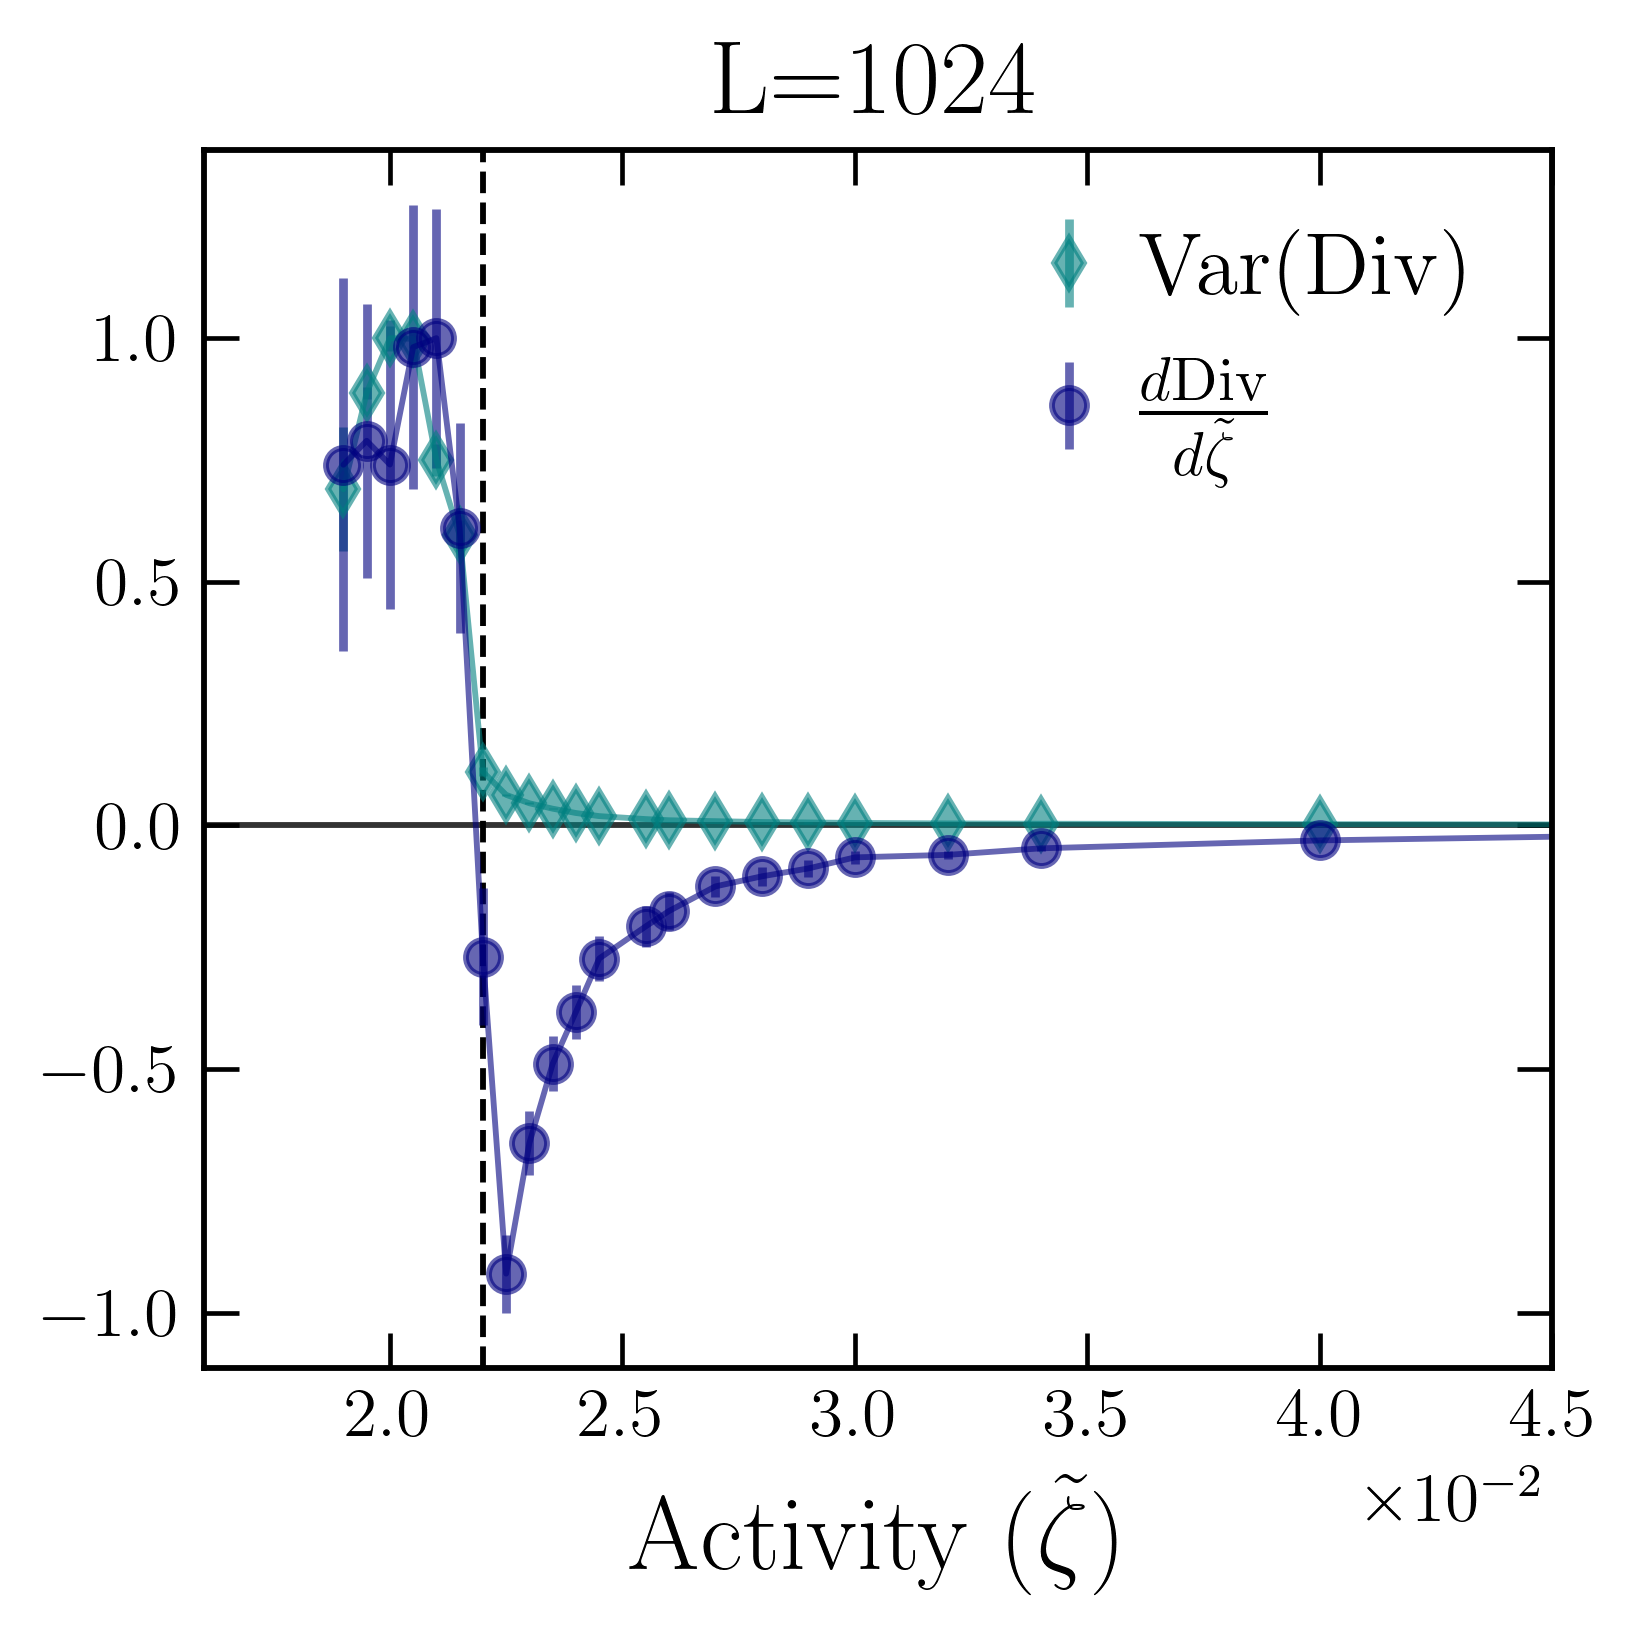

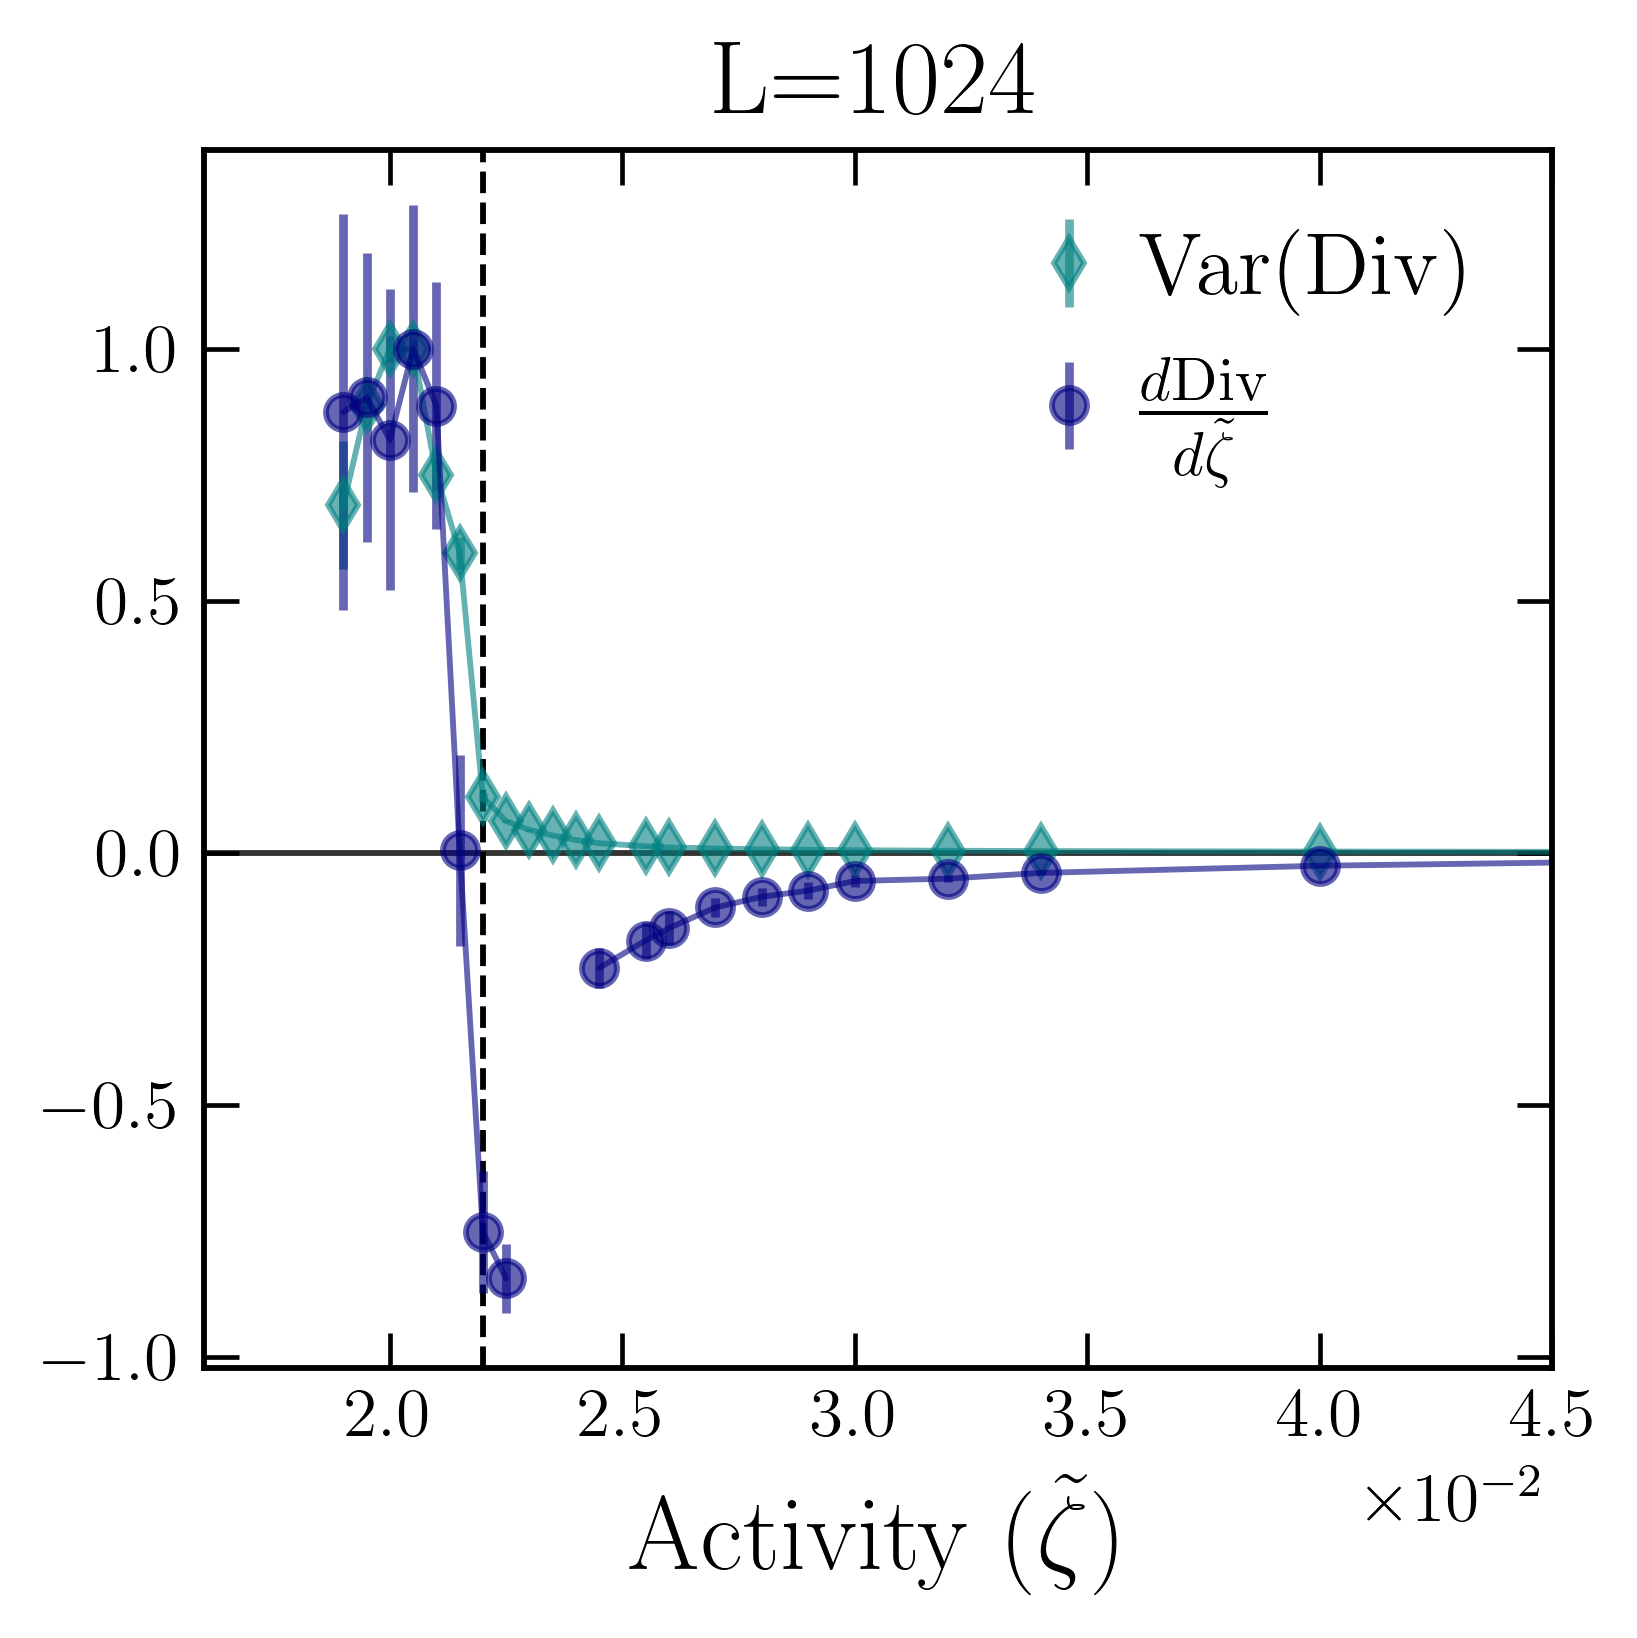

In [19]:
plot_abs = False
ac.plot_div_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=False, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);
ac.plot_div_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=use_min, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
ac.plot_cid_fluc(L_list = [LX],save_path=ac.figs_save_path, use_min=use_min, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
ac.plot_cid_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);
ac.plot_div_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);

In [ ]:
#### Plot cid/div and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);


In [ ]:
#### Plot cid/div fluc and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_fluc(save_path=figs_save_path,xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_fluc(save_path=figs_save_path, xlims=xlims, plot_abs=True, plot_div_per=True);

In [ ]:
## Plot cid/div moments
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);
fig1, ax1 = ac.plot_div_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


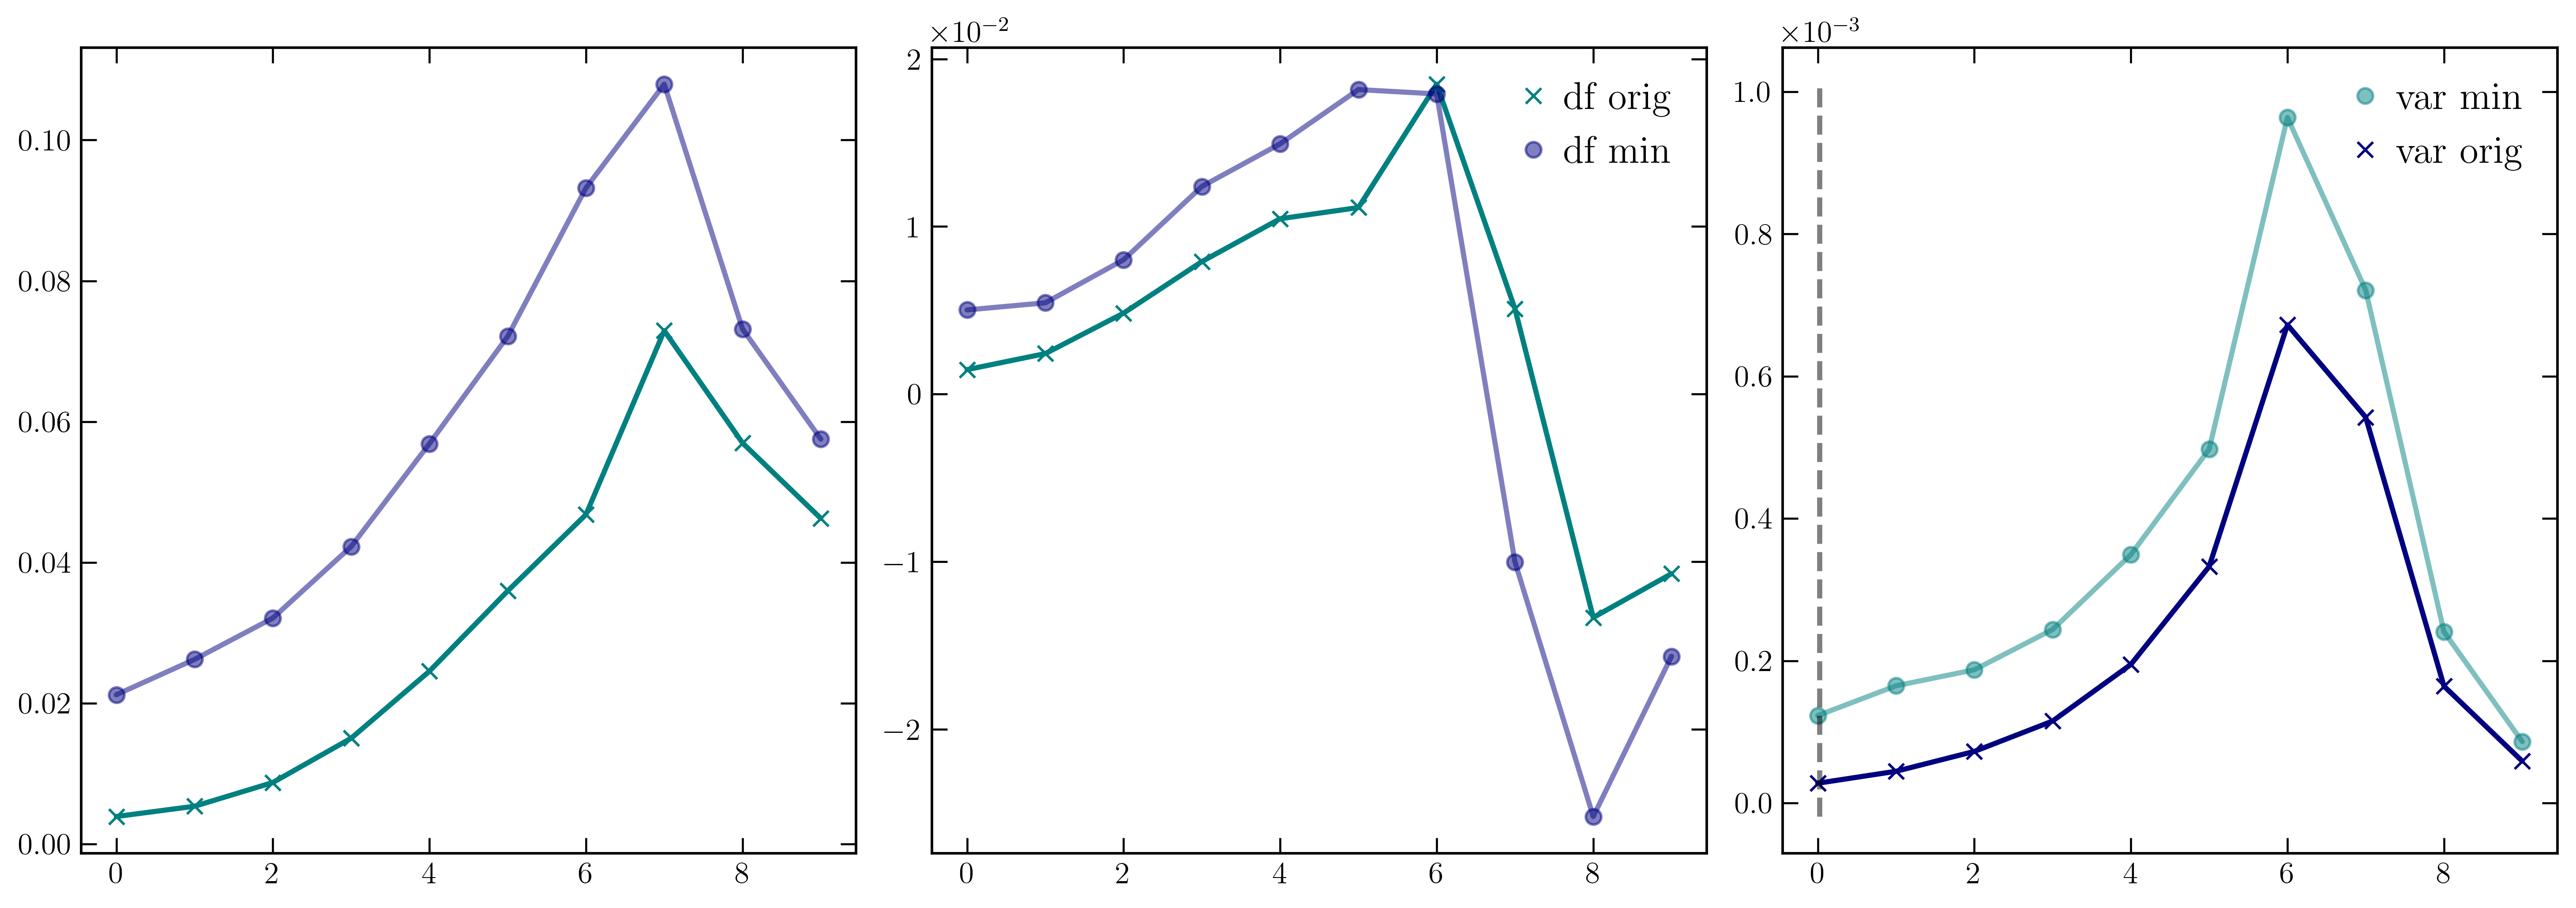

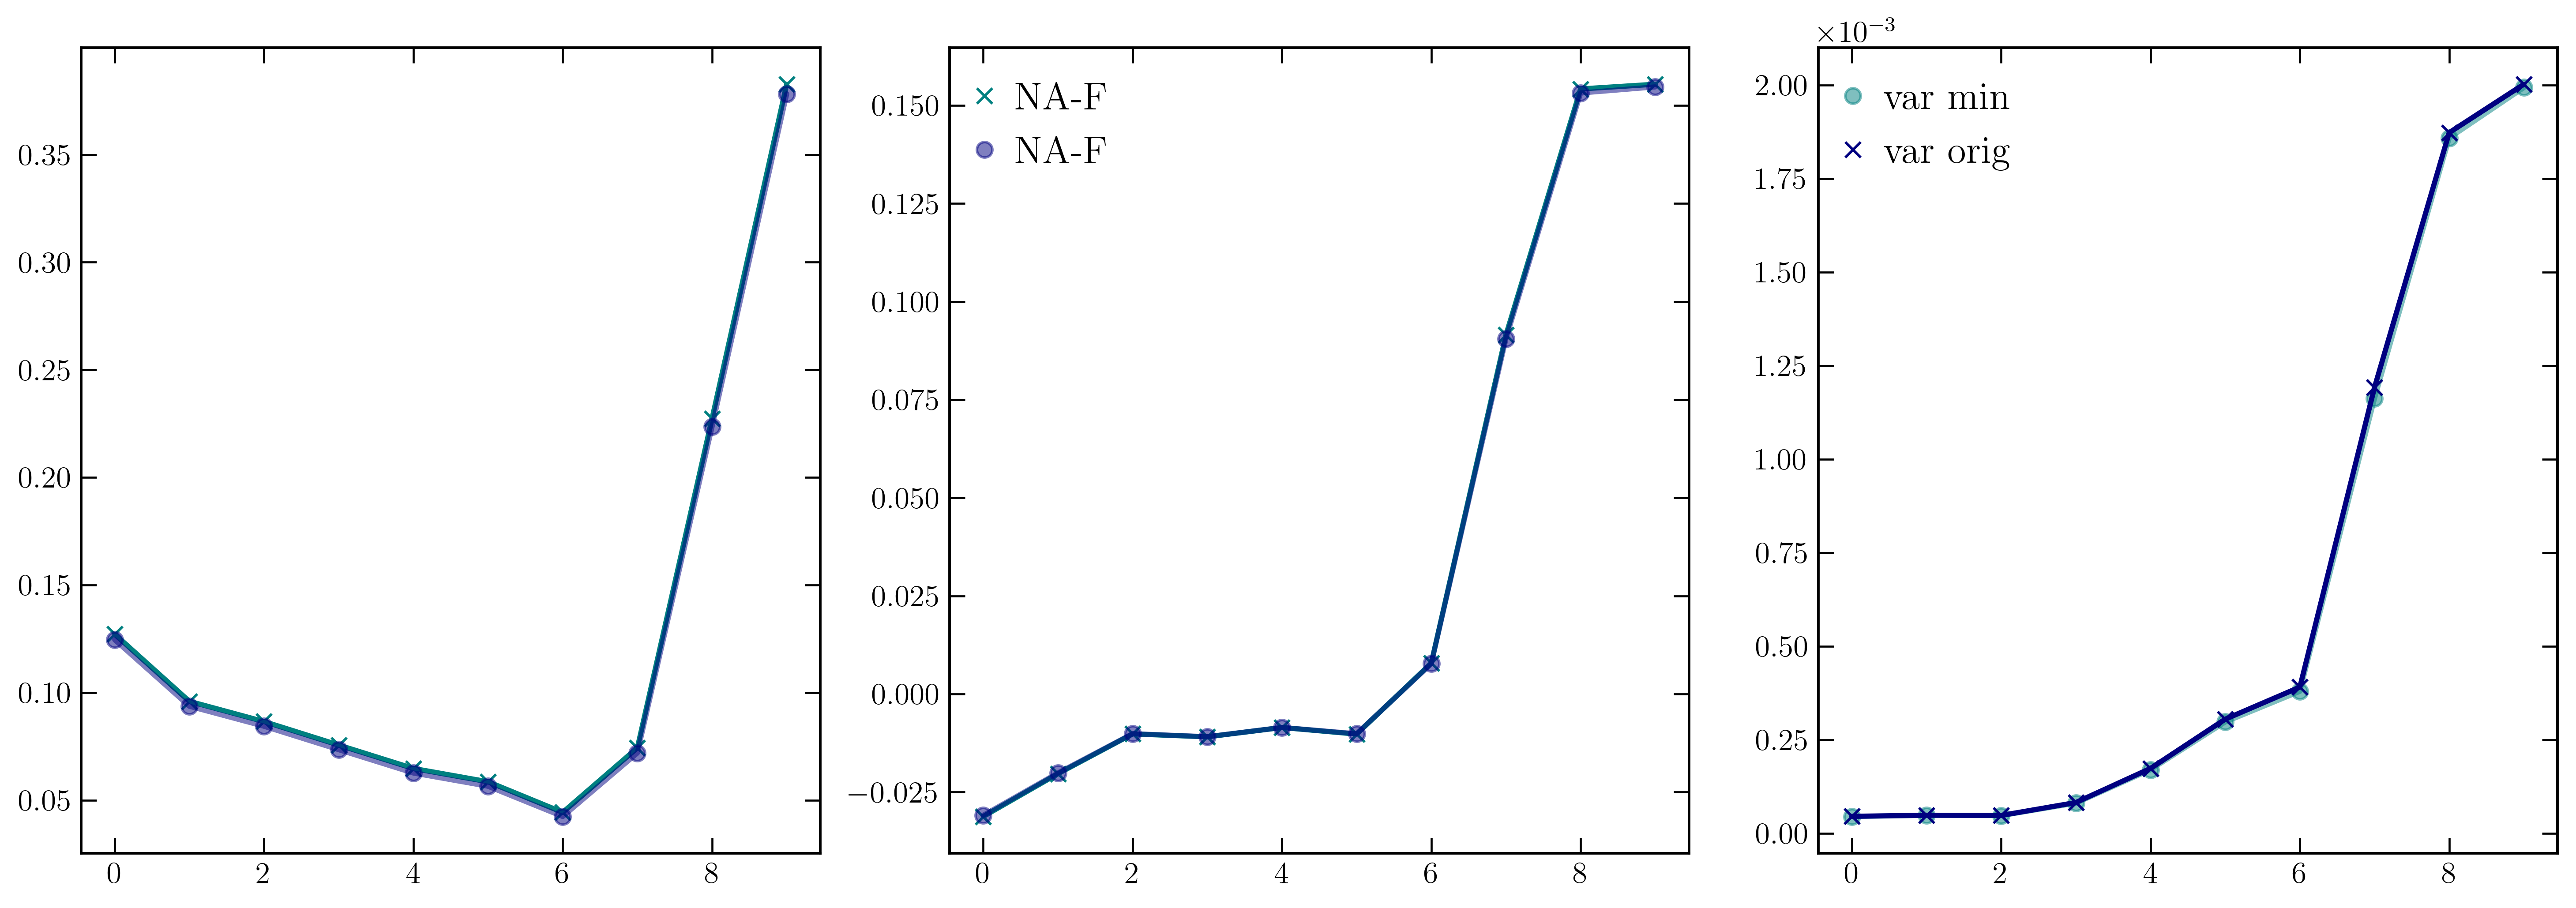

In [ ]:
npz_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024ndg\\cid_data_nb{nbits}cg{cg}.npz'
data = np.load(npz_path, allow_pickle=True)
data.files
cidf = data['cid_minmax']
fracf = data['frac_minmax']

LX=1024
#npz_path = r'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024f\\cid_data_nb5cg4.npz'
#data = np.load(npz_path, allow_pickle=True)
act_list = ac.act[LX]
#cidf = data['cid_minmax']
#fracf = data['frac_minmax']
cidf_tav, varf, varpf = calc_time_avs_ind_samples(cidf[...,0], ac.conv[ac.L_list[0]], Nexp=1,unc_multiplier=20,ddof=1)
fracf_tav, varff, varfpf = calc_time_avs_ind_samples(fracf[...,0], ac.conv[ac.L_list[0]], Nexp=1,unc_multiplier=20,ddof=1)
dcidf = calc_central_derivative(act_list, cidf_tav[:,0], cidf_tav[:,1])
dfracf = calc_central_derivative(act_list, fracf_tav[:,0], fracf_tav[:,1])

fig, ax = plt.subplots(ncols=3, figsize=(14,5))
ax[0].plot(act_list, 1-ac.frac_tav[LX][:,0], '-x')
ax[0].plot(act_list, 1-fracf_tav[:,0], '-o', alpha=0.5)
#ax[0].set_xlim(0.016, 0.045)
ax[1].plot(act_list, -1*ac.dfrac[LX][:,0], '-x', label='df orig')
ax[1].plot(act_list, -1*dfracf[:,0], '-o', alpha=0.5, label='df min')
#ax[2].plot(act_list, varfpf[:,0]/(1-fracf_tav[:,0]), '-o', alpha=0.5, label='var min')
#ax[2].plot(act_list, ac.frac_var[LX][:,0]/(1-ac.frac_tav[LX][:,0]), '-x', label='var orig')
ax[2].plot(act_list, varff[:]/(1), '-o', alpha=0.5, label='var min')
ax[2].plot(act_list, ac.frac_var[LX][:]/(1), '-x', label='var orig')
#ax[2].set_xlim(0.016, 0.045)    
ylim = ax[2].get_ylim()
ax[2].vlines(0.022, ylim[0],ylim[1],color='k', linestyle='--', alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
#ax[1].set_xlim(0.016, 0.045)

fig2, ax2 = plt.subplots(ncols=3, figsize=(14,5))
ax2[0].plot(act_list, ac.cid_tav[LX][:,0], '-x')
ax2[0].plot(act_list, cidf_tav[:,0], '-o', alpha=0.5)
#ax2[0].set_xlim(0.016, 0.045)
ax2[1].plot(act_list, ac.dcid[LX][:,0], '-x', label='NA-F')
ax2[1].plot(act_list, dcidf[:,0], '-o', alpha=0.5, label='NA-F')
#ax2[1].set_xlim(0.016, 0.045)
ax2[2].plot(act_list, varf[:], '-o', alpha=0.5, label='var min')
ax2[2].plot(act_list, ac.cid_var[LX][:], '-x', label='var orig')
#ax2[2].set_xlim(0.016, 0.045)

ax2[0].legend()
ax2[1].legend()
ax2[2].legend()

In [ ]:
cidf